In [6]:
# import os
# import pandas as pd
# import numpy as np
# 
# project_root = '/Users/home/Work/Projects/nisca'
# os.chdir(project_root)
# 
# data = pd.read_csv('datasets/Yahoo/ETF_prices.csv')
# 
# data = data[['price_date', 'adj_close', 'fund_symbol']]
# 
# data = data.sort_values(by=['fund_symbol', 'price_date'])
# data['return'] = data.groupby('fund_symbol')['adj_close'].pct_change()
# 
# data_pivot = data.pivot(index='price_date', columns='fund_symbol', values='return')
# data_pivot_cleaned = data_pivot.dropna(axis=1, how='all')
# 
# data_pivot_cleaned = data_pivot_cleaned.dropna(axis=0, how='all')
# 
# threshold = int(0.01 * data_pivot_cleaned.shape[1])
# data_pivot_cleaned = data_pivot_cleaned.dropna(thresh=threshold, axis=0)  # Drops rows with <70% valid data
# 
# threshold_columns = int(1 * data_pivot_cleaned.shape[0])
# returns_matrix = data_pivot_cleaned.dropna(thresh=threshold_columns, axis=1)  # Drops columns with <70% valid data
# 
# Y = returns_matrix.values  # Shape: [T, M]
# dates = returns_matrix.index
# funds = returns_matrix.columns
# T, M = Y.shape
# 
# print(f'Data ready for modeling with {T} time steps and {M} ETFs.')

Data ready for modeling with 5364 time steps and 23 ETFs.


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Set the number of latent factors (hyperparameter)
N = 5  # Adjust as needed

# Convert Y to a PyTorch tensor
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Shape: [T, M]

# Define the Encoder Network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, y_t):
        h = torch.relu(self.fc1(y_t))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Instantiate the encoder
hidden_dim = 512  # Adjust as needed
encoder = Encoder(input_dim=M, hidden_dim=hidden_dim, latent_dim=N)

# Initialize the Basis Matrix A as a PyTorch parameter
A = nn.Parameter(torch.rand(M, N, dtype=torch.float32))

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(list(encoder.parameters()) + [A], lr=learning_rate)

# Training settings
num_epochs = 10  # Adjust as needed
s_t_list = []  # To store exposures over time
loss_history = []  # To store loss values over epochs

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for t in range(T):
        y_t = Y_tensor[t]  # Shape: [M]

        # Forward pass through encoder
        mu, logvar = encoder(y_t)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_t = mu + std * eps
        s_t = torch.softmax(z_t, dim=0)  # Shape: [N]

        # Store s_t for analysis
        if epoch == num_epochs - 1:
            s_t_list.append(s_t.detach().numpy())

        # Reconstruction
        y_hat = torch.matmul(A, s_t)  # Shape: [M]

        # Compute losses
        recon_loss = nn.MSELoss()(y_hat, y_t)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss * 1e-4  # Adjust KLD weight as needed

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Enforce non-negativity on A
        with torch.no_grad():
            A.clamp_(min=0)

        total_loss += loss.item()

    avg_loss = total_loss / T
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}')

# Convert s_t_list to a NumPy array
s_t_array = np.array(s_t_list)  # Shape: [T, N]

# Convert A to a NumPy array
A_trained = A.detach().numpy()  # Shape: [M, N]

Epoch 1/10, Average Loss: 0.011713
Epoch 2/10, Average Loss: 0.000438
Epoch 3/10, Average Loss: 0.000221
Epoch 4/10, Average Loss: 0.000222
Epoch 5/10, Average Loss: 0.000218
Epoch 6/10, Average Loss: 0.000220
Epoch 7/10, Average Loss: 0.000221
Epoch 8/10, Average Loss: 0.000219
Epoch 9/10, Average Loss: 0.000220
Epoch 10/10, Average Loss: 0.000221


In [3]:
# # Create DataFrames
# df_A = pd.DataFrame(A_trained, index=funds, columns=[f'Factor_{i+1}' for i in range(N)])
# df_s_t = pd.DataFrame(s_t_array, index=dates, columns=[f'Factor_{i+1}' for i in range(N)])

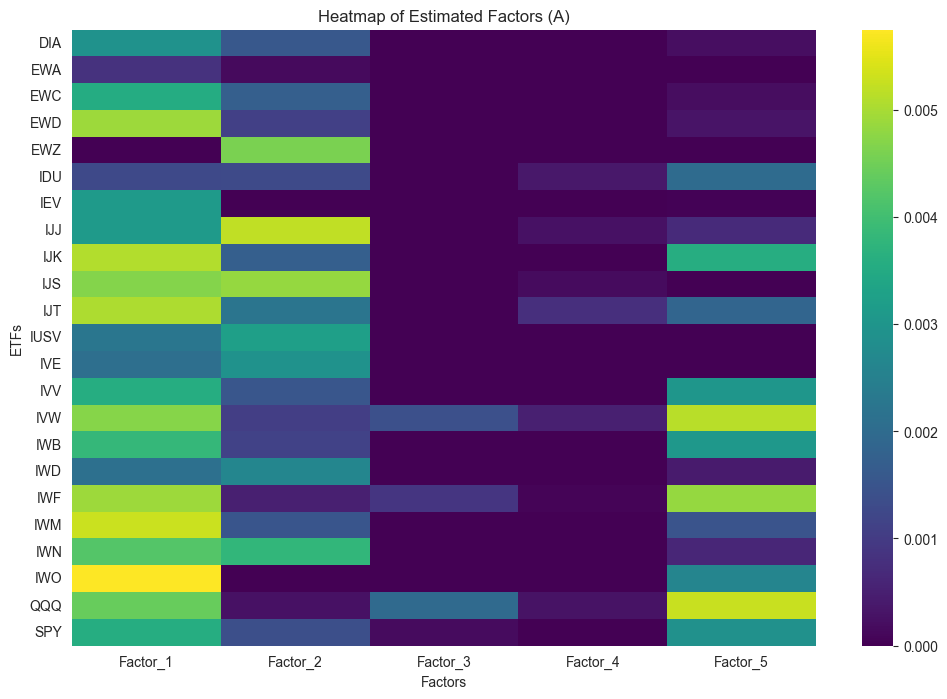

In [4]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# plt.figure(figsize=(12, 8))
# sns.heatmap(df_A, cmap='viridis')
# plt.title('Heatmap of Estimated Factors (A)')
# plt.xlabel('Factors')
# plt.ylabel('ETFs')
# plt.show()

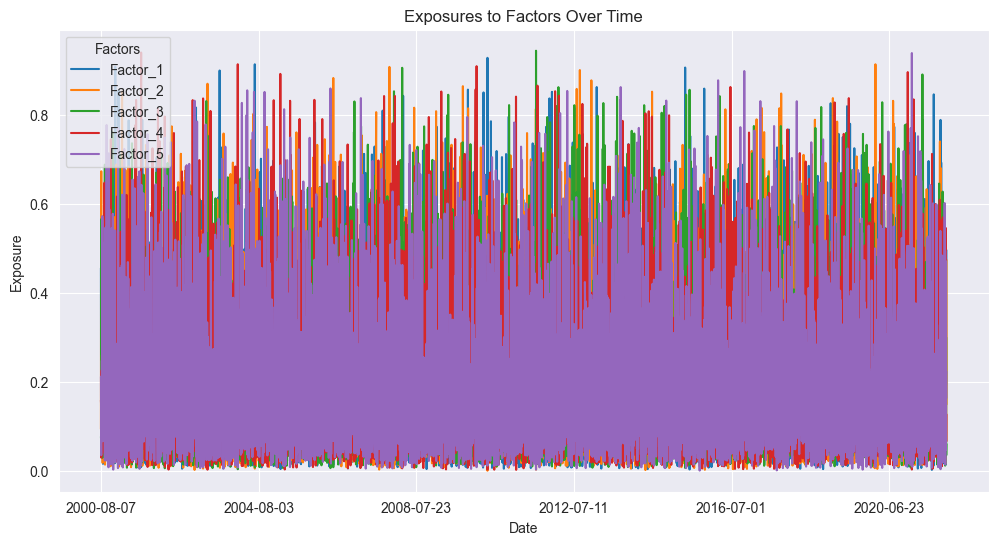

In [5]:
# df_s_t.plot(figsize=(12, 6))
# plt.title('Exposures to Factors Over Time')
# plt.xlabel('Date')
# plt.ylabel('Exposure')
# plt.legend(title='Factors')
# plt.show()

In [6]:
# from sklearn.metrics import mean_squared_error
# 
# Y_hat = s_t_array @ A_trained.T  # Shape: [T, M]
# mse = mean_squared_error(Y.flatten(), Y_hat.flatten())
# print(f'Reconstruction MSE: {mse:.6f}')

Reconstruction MSE: 0.000219


In [116]:
# total_variance = np.var(Y, ddof=1)
# residuals = Y - Y_hat
# residual_variance = np.var(residuals, ddof=1)
# explained_variance_ratio = 1 - (residual_variance / total_variance)
# print(f'Explained Variance Ratio: {explained_variance_ratio:.4f}')

Explained Variance Ratio: 0.0055


In [117]:
# from sklearn.decomposition import PCA
# # 
# pca = PCA(n_components=N)
# pca.fit(Y)
# Y_pca = pca.transform(Y)
# Y_pca_reconstructed = pca.inverse_transform(Y_pca)
# 
# mse_pca = mean_squared_error(Y.flatten(), Y_pca_reconstructed.flatten())
# explained_variance_pca = np.sum(pca.explained_variance_ratio_)
# print(f'PCA Reconstruction MSE: {mse_pca:.6f}')
# print(f'PCA Explained Variance Ratio: {explained_variance_pca:.4f}')

PCA Reconstruction MSE: 0.000015
PCA Explained Variance Ratio: 0.9329


In [7]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.metrics import mean_squared_error
# import cvxpy as cp  # For optimization

In [8]:
expected_factor_returns = s_t_array.mean(axis=0)  # Shape: [N]
# Expected returns for assets
expected_returns_vae = A_trained @ expected_factor_returns  # Shape: [M]

M = A_trained.shape[0]  # Number of assets
w = cp.Variable(M)  # Portfolio weights


constraints = [
    cp.sum(w) == 1,       # Weights sum to 1
    w >= 0,               # No short selling
    w <= 0.1              # Maximum 10% allocation per asset (adjust as needed)
]

# Objective: Maximize expected return
objective = cp.Maximize(expected_returns_vae @ w)

prob = cp.Problem(objective, constraints)
prob.solve()

# Extract optimal weights
optimal_weights_vae = w.value  # Shape: [M]

In [9]:
# from sklearn.decomposition import PCA
# 
# # Number of components (same as N)
# pca = PCA(n_components=N)
# pca.fit(Y)
# 
# # Principal components (factors)
# components_pca = pca.components_.T  # Shape: [M, N]
# 
# # Scores (exposures)
# scores_pca = pca.transform(Y)  # Shape: [T, N]

In [10]:
# Estimate expected factor returns as the mean of factor scores
expected_factor_returns_pca = scores_pca.mean(axis=0)  # Shape: [N]
# Expected returns for assets
expected_returns_pca = components_pca @ expected_factor_returns_pca  # Shape: [M]

# Define optimization variables
w_pca = cp.Variable(M)

# Define constraints
constraints_pca = [
    cp.sum(w_pca) == 1,
    w_pca >= 0,
    w_pca <= 0.1
]

# Define objective function
objective_pca = cp.Maximize(expected_returns_pca @ w_pca)

# Solve optimization problem
prob_pca = cp.Problem(objective_pca, constraints_pca)
prob_pca.solve()

# Extract optimal weights
optimal_weights_pca = w_pca.value  # Shape: [M]

In [11]:
# # Split data into training and test sets
# split_index = int(0.8 * T)
# Y_train = Y[:split_index]
# Y_test = Y[split_index:]
# dates_train = dates[:split_index]
# dates_test = dates[split_index:]
# 
# # Corresponding exposures for VAE
# s_t_train = s_t_array[:split_index]
# s_t_test = s_t_array[split_index:]
# 
# # PCA scores for training and testing
# scores_pca_train = scores_pca[:split_index]
# scores_pca_test = scores_pca[split_index:]

In [12]:
# # Compute daily returns for VAE portfolio
# portfolio_returns_vae = Y_test @ optimal_weights_vae  # Shape: [T_test]
# 
# # Compute daily returns for PCA portfolio
# portfolio_returns_pca = Y_test @ optimal_weights_pca  # Shape: [T_test]
# 
# # Cumulative returns
# cumulative_returns_vae = np.cumprod(1 + portfolio_returns_vae) - 1
# cumulative_returns_pca = np.cumprod(1 + portfolio_returns_pca) - 1

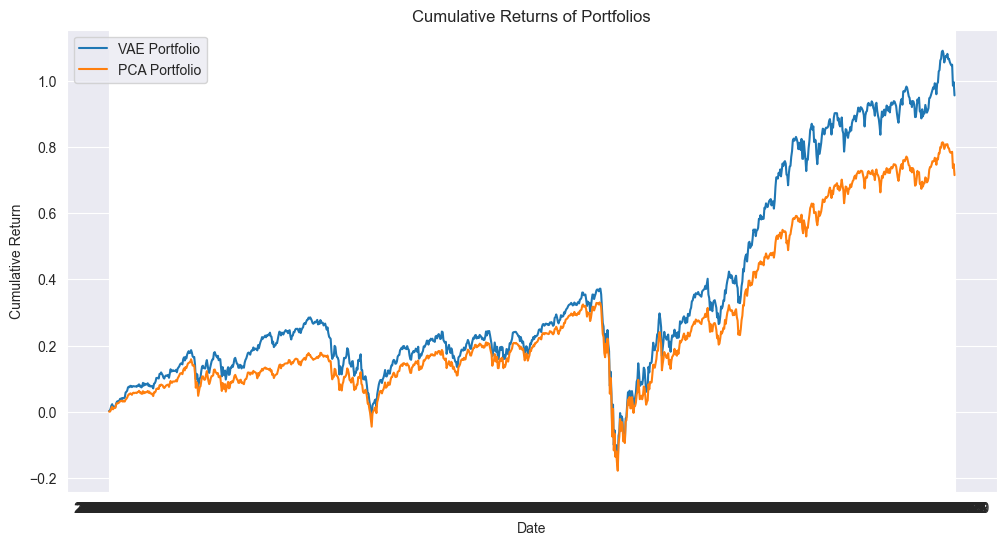

In [13]:
# plt.figure(figsize=(12, 6))
# plt.plot(dates_test, cumulative_returns_vae, label='VAE Portfolio')
# plt.plot(dates_test, cumulative_returns_pca, label='PCA Portfolio')
# plt.title('Cumulative Returns of Portfolios')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Return')
# plt.legend()
# plt.grid(True)
# plt.show()

In [14]:
# def calculate_performance_metrics(returns, risk_free_rate=0.0):
#     import pandas as pd
#     returns = pd.Series(returns)
#     mean_return = returns.mean() * 252  # Annualized
#     volatility = returns.std() * np.sqrt(252)  # Annualized
#     sharpe_ratio = (mean_return - risk_free_rate) / volatility
#     cumulative_return = (1 + returns).prod() - 1
#     max_drawdown = (returns.cumsum().expanding().max() - returns.cumsum()).max()
#     return {
#         'Mean Return': mean_return,
#         'Volatility': volatility,
#         'Sharpe Ratio': sharpe_ratio,
#         'Cumulative Return': cumulative_return,
#         'Max Drawdown': max_drawdown
#     }

In [15]:
# metrics_vae = calculate_performance_metrics(portfolio_returns_vae)
# metrics_pca = calculate_performance_metrics(portfolio_returns_pca)
# 
# # Display metrics
# df_metrics = pd.DataFrame([metrics_vae, metrics_pca], index=['VAE Portfolio', 'PCA Portfolio'])
# print(df_metrics)

               Mean Return  Volatility  Sharpe Ratio  Cumulative Return  \
VAE Portfolio     0.184120    0.229456      0.802421           0.955533   
PCA Portfolio     0.149671    0.213306      0.701674           0.714740   

               Max Drawdown  
VAE Portfolio      0.446509  
PCA Portfolio      0.445697  


Pretraining Epoch 1/10, Average Loss: 0.016197
Pretraining Epoch 2/10, Average Loss: 0.000877
Pretraining Epoch 3/10, Average Loss: 0.000216
Pretraining Epoch 4/10, Average Loss: 0.000218
Pretraining Epoch 5/10, Average Loss: 0.000217
Pretraining Epoch 6/10, Average Loss: 0.000218
Pretraining Epoch 7/10, Average Loss: 0.000219
Pretraining Epoch 8/10, Average Loss: 0.000215
Pretraining Epoch 9/10, Average Loss: 0.000219
Pretraining Epoch 10/10, Average Loss: 0.000220


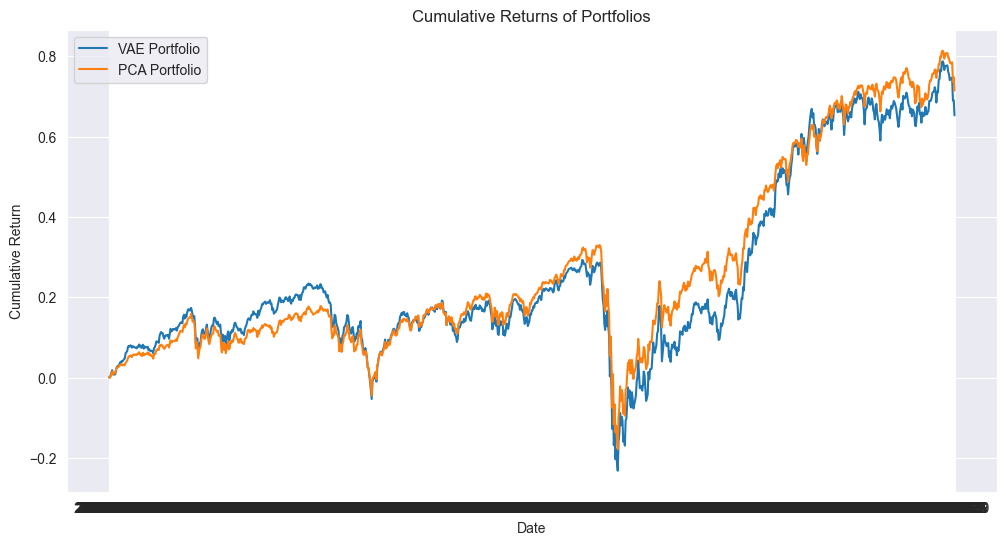

In [5]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Data Preparation
project_root = '/Users/home/Work/Projects/nisca'
os.chdir(project_root)

data = pd.read_csv('datasets/Yahoo/ETF_prices.csv')
data = data[['price_date', 'adj_close', 'fund_symbol']]
data = data.sort_values(by=['fund_symbol', 'price_date'])
data['return'] = data.groupby('fund_symbol')['adj_close'].pct_change()

data_pivot = data.pivot(index='price_date', columns='fund_symbol', values='return')
data_pivot_cleaned = data_pivot.dropna(axis=1, how='all')
data_pivot_cleaned = data_pivot_cleaned.dropna(axis=0, how='all')

threshold = int(0.01 * data_pivot_cleaned.shape[1])
data_pivot_cleaned = data_pivot_cleaned.dropna(thresh=threshold, axis=0)

threshold_columns = int(1 * data_pivot_cleaned.shape[0])
returns_matrix = data_pivot_cleaned.dropna(thresh=threshold_columns, axis=1)

Y = returns_matrix.values  # Shape: [T, M]
dates = returns_matrix.index
funds = returns_matrix.columns
T, M = Y.shape

# Split the data: 80% for training, 20% for testing
split_index = int(0.8 * T)
Y_train = Y[:split_index]  # Training set (first 80% of data)
Y_test = Y[split_index:]  # Test set (remaining 20% of data)
dates_train = dates[:split_index]
dates_test = dates[split_index:]

# Convert Y_train and Y_test to PyTorch tensors
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Step 2: Define the VAE Model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, y_t):
        h = torch.relu(self.fc1(y_t))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Initialize encoder, optimizer, and basis matrix A
N = 5  # Number of latent factors
hidden_dim = 512
encoder = Encoder(input_dim=M, hidden_dim=hidden_dim, latent_dim=N)

A = nn.Parameter(torch.rand(M, N, dtype=torch.float32))
optimizer = optim.Adam(list(encoder.parameters()) + [A], lr=0.001)

# Step 3: Pretrain the VAE on the First 80% of Data
num_epochs = 10  # Adjust as needed
s_t_list = []  # To store latent factors
loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    for t in range(Y_train_tensor.shape[0]):
        y_t = Y_train_tensor[t]
        mu, logvar = encoder(y_t)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_t = mu + std * eps
        s_t = torch.softmax(z_t, dim=0)

        y_hat = torch.matmul(A, s_t)
        recon_loss = nn.MSELoss()(y_hat, y_t)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss * 1e-4

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Replace in-place operation with out-of-place operation
        with torch.no_grad():
            A.copy_(A.clamp(min=0))

        total_loss += loss.item()

    avg_loss = total_loss / Y_train_tensor.shape[0]
    loss_history.append(avg_loss)
    print(f'Pretraining Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}')

# Store the learned latent factors and basis matrix after pretraining
s_t_array = np.array([encoder(Y_train_tensor[i])[0].detach().numpy() for i in range(Y_train_tensor.shape[0])])
A_trained = A.detach().numpy()

# Step 4: PCA Baseline for Comparison
pca = PCA(n_components=N)
pca.fit(Y_train)
components_pca = pca.components_.T
scores_pca = pca.transform(Y_train)

# Step 5: Initial Portfolio Optimization After Pretraining
expected_factor_returns_vae = s_t_array.mean(axis=0)
expected_returns_vae = A_trained @ expected_factor_returns_vae

expected_factor_returns_pca = scores_pca.mean(axis=0)
expected_returns_pca = components_pca @ expected_factor_returns_pca

M = A_trained.shape[0]
w_vae_var = cp.Variable(M)
w_pca_var = cp.Variable(M)

constraints = [cp.sum(w_vae_var) == 1, w_vae_var >= 0, w_vae_var <= 0.1]
constraints_pca = [cp.sum(w_pca_var) == 1, w_pca_var >= 0, w_pca_var <= 0.1]

objective_vae = cp.Maximize(expected_returns_vae @ w_vae_var)
objective_pca = cp.Maximize(expected_returns_pca @ w_pca_var)

prob_vae = cp.Problem(objective_vae, constraints)
prob_pca = cp.Problem(objective_pca, constraints_pca)

prob_vae.solve()
prob_pca.solve()

optimal_weights_vae = w_vae_var.value
optimal_weights_pca = w_pca_var.value

# Step 6: Compute Daily Returns and Cumulative Returns for Test Set
portfolio_returns_vae = Y_test @ optimal_weights_vae  # Shape: [T_test]
portfolio_returns_pca = Y_test @ optimal_weights_pca  # Shape: [T_test]

# Cumulative returns
cumulative_returns_vae = np.cumprod(1 + portfolio_returns_vae) - 1
cumulative_returns_pca = np.cumprod(1 + portfolio_returns_pca) - 1

# Step 7: Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(dates_test, cumulative_returns_vae, label='VAE Portfolio')
plt.plot(dates_test, cumulative_returns_pca, label='PCA Portfolio')
plt.title('Cumulative Returns of Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()